In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Classification

*Supervised* machine learning techniques involve training a model to operate on a set of *features* and predict a *label* using a dataset that includes some already-known label values. You can think of this function like this, in which ***y*** represents the label we want to predict and ***X*** represents the vector of features the model uses to predict it.

$$y = f([x_1, x_2, x_3, ...])$$


*Classification* is a form of supervised machine learning in which you train a model to use the features (the ***x*** values in our function) to predict a label (***y***) that calculates the probability of the observed case belonging to each of a number of possible classes, and predicting an appropriate label. The simplest form of classification is *binary* classification, in which the label is 0 or 1, representing one of two classes; for example, "True" or "False"; "Internal" or "External"; "Profitable" or "Non-Profitable"; and so on. 

## Binary Classification

In this notebook, we will focus on an example of *binary classification*, where the model must predict a label that belongs to one of two classes. In this exercise, we'll train a binary classifier to predict whether or not a patient should be tested for diabetes based on some medical data.

### Explore the data

Run the following cell to load a CSV file of patent data into a **Pandas** dataframe:

> **Citation**: The diabetes dataset used in this exercise is based on data originally collected by the National Institute of Diabetes and Digestive and Kidney Diseases.

In [2]:
import pandas as pd

# load the training dataset
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/diabetes.csv
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

--2022-02-27 08:44:41--  https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/Data/ml-basics/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 776415 (758K) [text/plain]
Saving to: ‘diabetes.csv’

diabetes.csv        100%[===================>] 758.22K  --.-KB/s    in 0.02s   

2022-02-27 08:44:42 (44.4 MB/s) - ‘diabetes.csv’ saved [776415/776415]



,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


Note that the final column in the dataset (**Diabetic**) contains the value ***0*** for patients who tested negative for diabetes, and ***1*** for patients who tested positive. This is the label that we will train our model to predict; most of the other columns (**Pregnancies**,**PlasmaGlucose**,**DiastolicBloodPressure**, and so on) are the features we will use to predict the **Diabetic** label.

Let's separate the features from the labels - we'll call the features ***X*** and the label ***y***:

In [3]:
# Separate Features and Labels
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
label = 'Diabetic'
X,y = diabetes[features].values, diabetes[label].values

for n in range(0,4):
    print("Patient", str(n+1), "\n  Features:",list(X[n]), "\n  Label:", y[n])

Patient 1 
  Features: [0.0, 171.0, 80.0, 34.0, 23.0, 43.50972593, 1.213191354, 21.0] 
  Label: 0
Patient 2 
  Features: [8.0, 92.0, 93.0, 47.0, 36.0, 21.24057571, 0.158364981, 23.0] 
  Label: 0
Patient 3 
  Features: [7.0, 115.0, 47.0, 52.0, 35.0, 41.51152348, 0.079018568, 23.0] 
  Label: 0
Patient 4 
  Features: [9.0, 103.0, 78.0, 25.0, 304.0, 29.58219193, 1.282869847, 43.0] 
  Label: 1


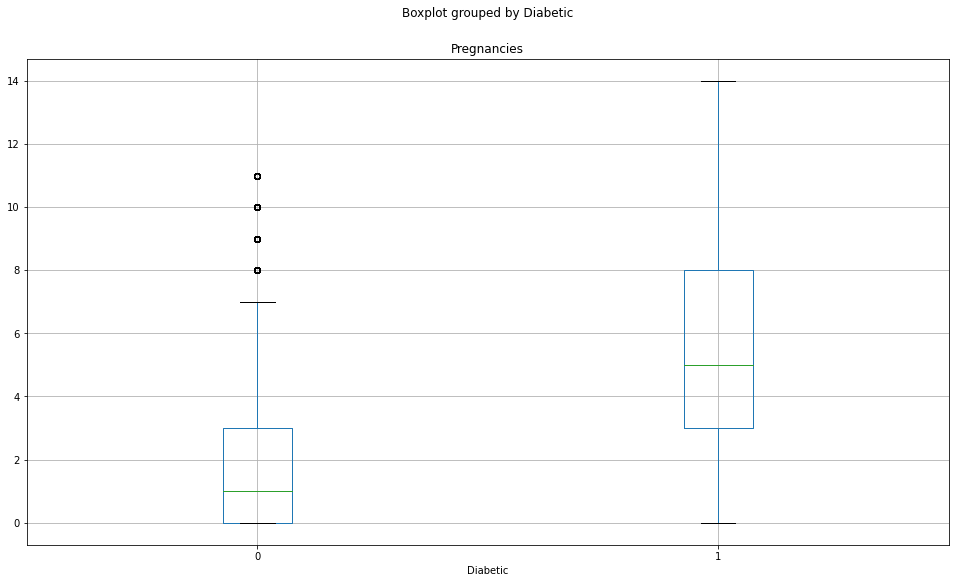

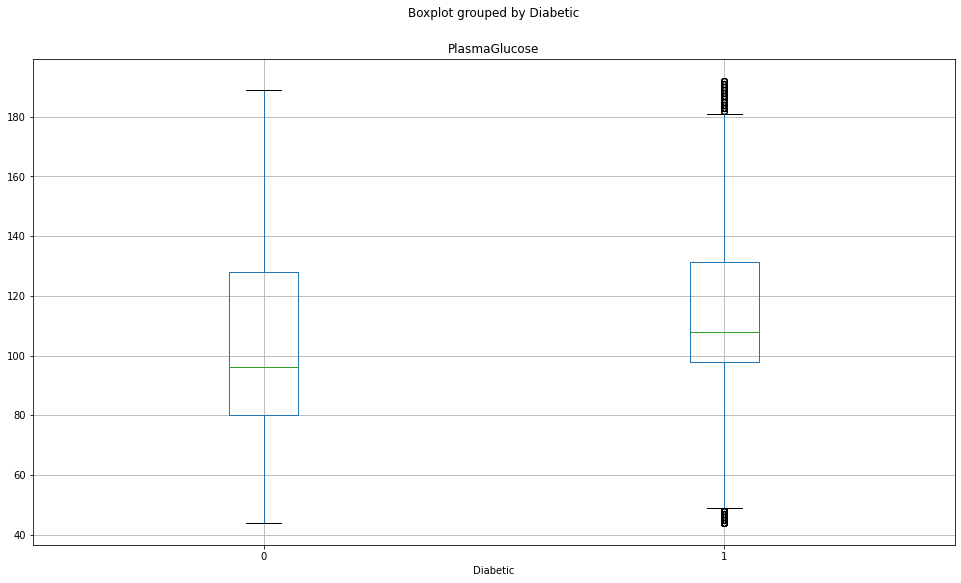

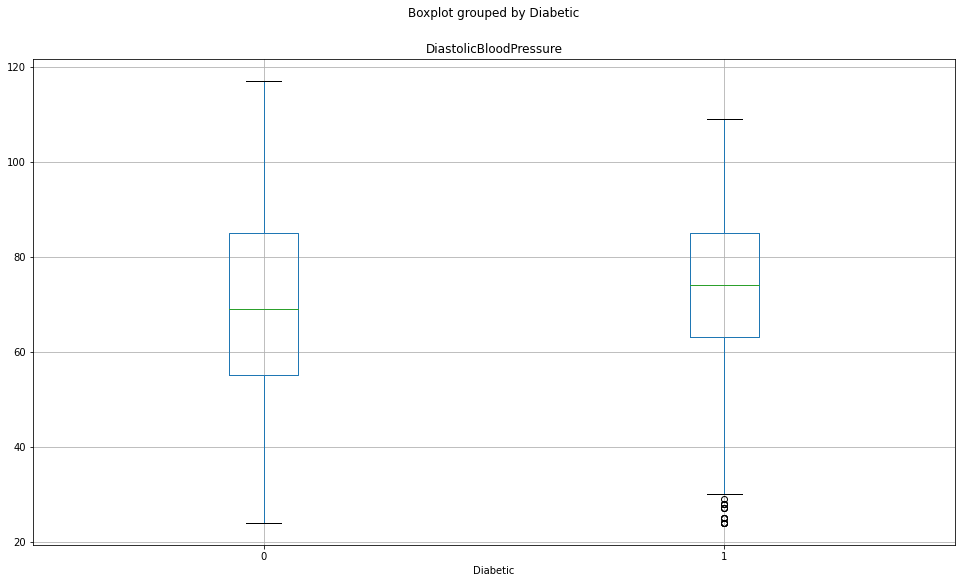

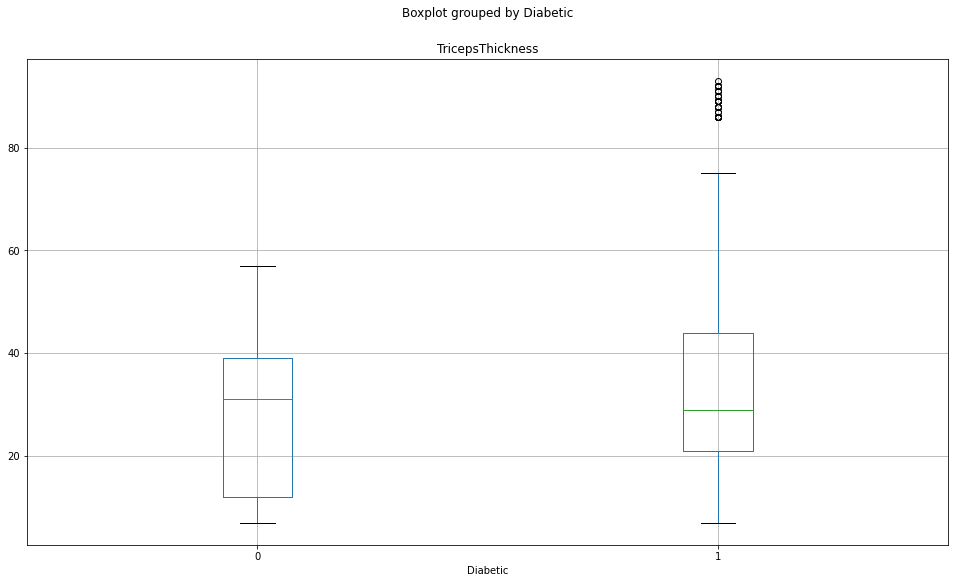

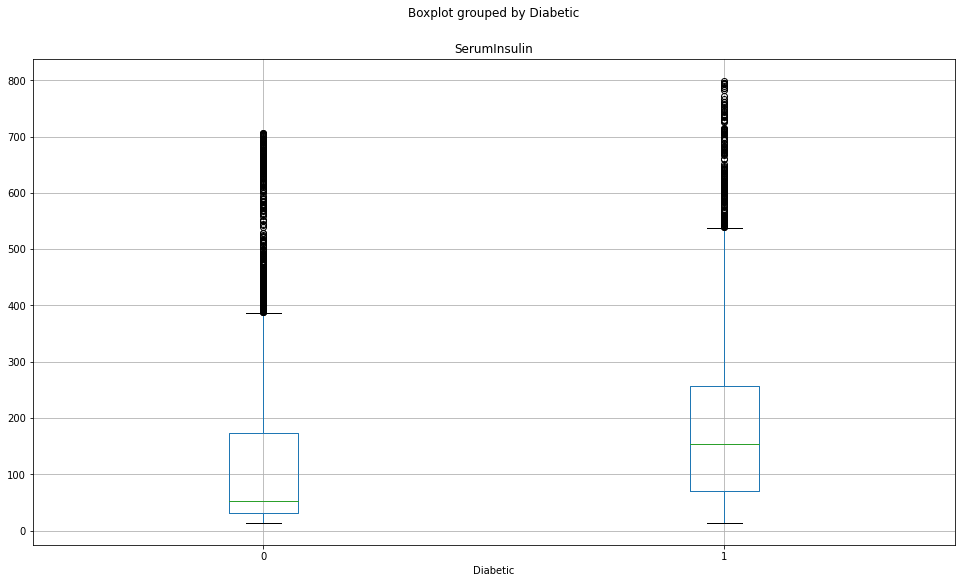

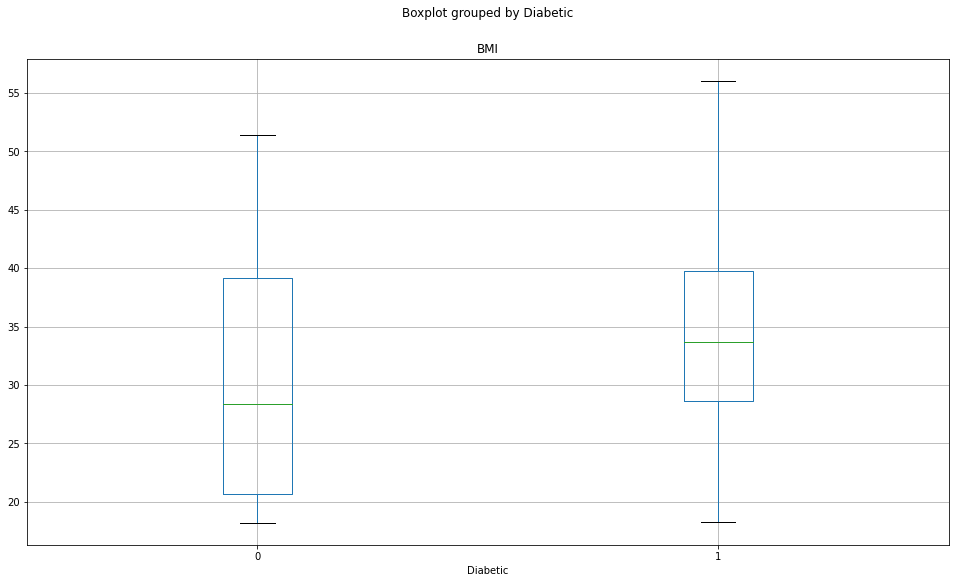

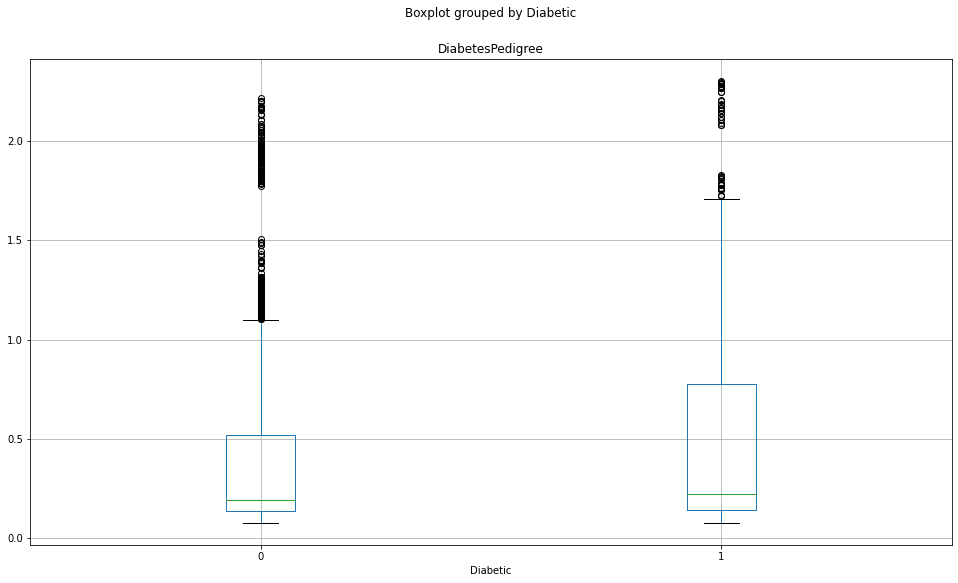

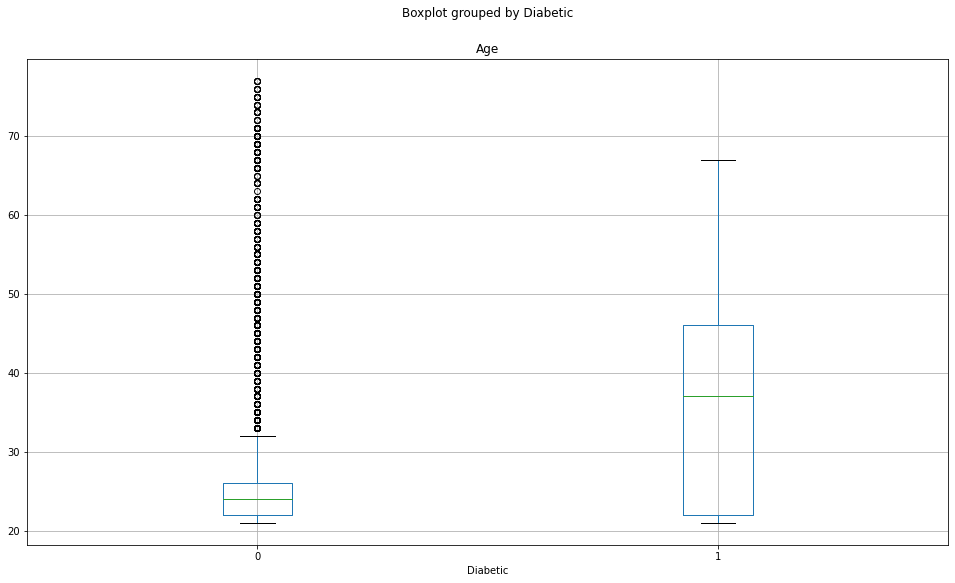

In [4]:
# Let us compare the distributions
from matplotlib import pyplot as plt
%matplotlib inline
features = ['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']
for col in features:
    diabetes.boxplot(column=col, by="Diabetic", figsize=(16,9))
    plt.title(col)
plt.show()

For some of the features, there's a noticeable difference in the distribution for each label value. In particular, **Pregnancies** and **Age** show markedly different distributions for diabetic patients than for non-diabetic patients. These features may help predict whether or not a patient is diabetic.

### Split the data

Our dataset includes known values for the label, so we can use this to train a classifier so that it finds a statistical relationship between the features and the label value; but how will we know if our model is any good? How do we know it will predict correctly when we use it with new data that it wasn't trained with? Well, we can take advantage of the fact we have a large dataset with known label values, use only some of it to train the model, and hold back some to test the trained model - enabling us to compare the predicted labels with the already known labels in the test set.

In Python, the **scikit-learn** package contains a large number of functions we can use to build a machine learning model - including a **train_test_split** function that ensures we get a statistically random split of training and test data. We'll use that to split the data into 70% for training and hold back 30% for testing.

In [6]:
from sklearn.model_selection import train_test_split

# Split data 70-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 10500
Test cases: 4500


### Train and Evaluate a Binary Classification Model
OK, now we're ready to train our model by fitting the training features (**X_train**) to the training labels (**y_train**). There are various algorithms we can use to train the model. In this example, we'll use *Logistic Regression*, which (despite its name) is a well-established algorithm for classification. In addition to the training features and labels, we'll need to set a *regularization* parameter. This is used to counteract any bias in the sample, and help the model generalize well by avoiding *overfitting* the model to the training data.

> **Note**: Parameters for machine learning algorithms are generally referred to as *hyperparameters* (to a data scientist, *parameters* are values in the data itself - *hyperparameters* are defined externally from the data!)

In [7]:
# Train the model
from sklearn.linear_model import LogisticRegression

# Set regulation rate
reg = 0.01

# Train a logistic regression model on the training set
model = LogisticRegression(C=1/reg, solver = "liblinear").fit(X_train, y_train)
print(model)



LogisticRegression(C=100.0, solver='liblinear')


In [8]:
# Evaluate the model

predictions = model.predict(X_test)
print('Predicted labels: ', predictions)
print('Actual labels:    ' ,y_test)

Predicted labels:  [0 0 0 ... 0 1 0]
Actual labels:     [0 0 1 ... 1 1 1]


In [10]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_test, predictions))

Accuracy:  0.7893333333333333


The accuracy is returned as a decimal value - a value of 1.0 would mean that the model got 100% of the predictions right; while an accuracy of 0.0 is, well, pretty useless! 


## Summary

Here we prepared our data by splitting it into test and train datasets, and applied logistic regression - a way of applying binary labels to our data. Our model was able to predict whether patients had diabetes with what appears like reasonable accuracy. But is this good enough? In the next notebook we will look at alternatives to accuracy that can be much more useful in machine learning.**

In [11]:
from sklearn. metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.88      0.85      2986
           1       0.72      0.60      0.66      1514

    accuracy                           0.79      4500
   macro avg       0.77      0.74      0.75      4500
weighted avg       0.78      0.79      0.78      4500



The classification report includes the following metrics for each class  (0 and 1)

> note that the header row may not line up with the values!

* *Precision*: Of the predictions the model made for this class, what proportion were correct?
* *Recall*: Out of all of the instances of this class in the test dataset, how many did the model identify?
* *F1-Score*: An average metric that takes both precision and recall into account.
* *Support*: How many instances of this class are there in the test dataset?

The classification report also includes averages for these metrics, including a weighted average that allows for the imbalance in the number of cases of each class.

Because this is a *binary* classification problem, the ***1*** class is considered *positive* and its precision and recall are particularly interesting - these in effect answer the questions:

- Of all the patients the model predicted are diabetic, how many are actually diabetic?
- Of all the patients that are actually diabetic, how many did the model identify?

You can retrieve these values on their own by using the **precision_score** and **recall_score** metrics in scikit-learn (which by default assume a binary classification model).

In [12]:
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))

Overall Precision: 0.7242472266244057
Overall Recall: 0.6036988110964333


In [13]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print (cm)

[[2638  348]
 [ 600  914]]


Until now, we've considered the predictions from the model as being either 1 or 0 class labels. Actually, things are a little more complex than that. Statistical machine learning algorithms, like logistic regression, are based on probability; so what actually gets predicted by a binary classifier is the probability that the label is true (P(y)) and the probability that the label is false (1 - P(y)). A threshold value of 0.5 is used to decide whether the predicted label is a 1 (P(y) > 0.5) or a 0 (P(y) <= 0.5). You can use the predict_proba method to see the probability pairs for each case:



In [14]:
y_scores = model.predict_proba(X_test)
print(y_scores)

[[0.81658292 0.18341708]
 [0.96304483 0.03695517]
 [0.80875187 0.19124813]
 ...
 [0.60694341 0.39305659]
 [0.10652842 0.89347158]
 [0.63857628 0.36142372]]


The decision to score a prediction as a 1 or a 0 depends on the threshold to which the predicted probabilities are compared. If we were to change the threshold, it would affect the predictions; and therefore change the metrics in the confusion matrix. A common way to evaluate a classifier is to examine the true positive rate (which is another name for recall) and the false positive rate for a range of possible thresholds. These rates are then plotted against all possible thresholds to form a chart known as a received operator characteristic (ROC) chart, like this:



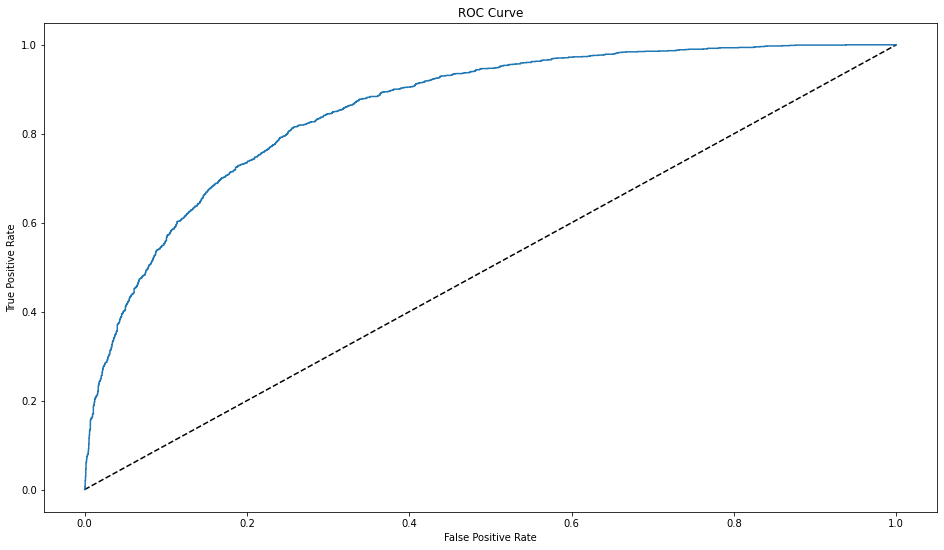

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(16, 9))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The ROC chart shows the curve of the true and false positive rates for different threshold values between 0 and 1. A perfect classifier would have a curve that goes straight up the left side and straight across the top. The diagonal line across the chart represents the probability of predicting correctly with a 50/50 random prediction; so you obviously want the curve to be higher than that (or your model is no better than simply guessing!).

The area under the curve (AUC) is a value between 0 and 1 that quantifies the overall performance of the model. The closer to 1 this value is, the better the model. Once again, scikit-Learn includes a function to calculate this metric.

In [17]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, y_scores[:,1])
print("AUC: " + str(auc))

AUC: 0.8568431632957323


### Perform preprocessing in a pipeline

In this case, the ROC curve and its AUC indicate that the model performs better than a random guess which is not bad considering we performed very little preprocessing of the data.

In practice, it's common to perform some preprocessing of the data to make it easier for the algorithm to fit a model to it. There's a huge range of preprocessing transformations you can perform to get your data ready for modeling, but we'll limit ourselves to a few common techniques:

- Scaling numeric features so they're on the same scale. This prevents features with large values from producing coefficients that disproportionately affect the predictions.
- Encoding categorical variables. For example, by using a *one hot encoding* technique you can create individual binary (true/false) features for each possible category value.

To apply these preprocessing transformations, we'll make use of a Scikit-Learn feature named *pipelines*. These enable us to define a set of preprocessing steps that end with an algorithm. You can then fit the entire pipeline to the data, so that the model encapsulates all of the preprocessing steps as well as the regression algorithm. This is useful, because when we want to use the model to predict values from new data, we need to apply the same transformations (based on the same statistical distributions and category encodings used with the training data).

>**Note**: The term *pipeline* is used extensively in machine learning, often to mean very different things! In this context, we're using it to refer to pipeline objects in Scikit-Learn, but you may see it used elsewhere to mean something else.


In [19]:
# Train the model 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np

In [27]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np

# Define preprocessing for numeric columns (normalize them so they're on the same scale)
numeric_features = [0,1,2,3,4,5,6]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode the Age column)
categorical_features = [7]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', LogisticRegression(C=1/reg, solver="liblinear"))])


# fit the pipeline to train a logistic regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('logregressor',
                 LogisticRegression(C=100.0, solver='liblinear'))])


The pipeline encapsulates the preprocessing steps as well as model training.

Let's use the model trained by this pipeline to predict labels for our test set, and compare the performance metrics with the basic model we created previously.

Confusion matrix: 
 [[2667  319]
 [ 406 1108]] 

Accuracy: 
 0.8388888888888889
Overall Precision: 
 0.7764540995094604
Overall Recall: 
 0.7318361955085865
AUC: 0.9202442751333612


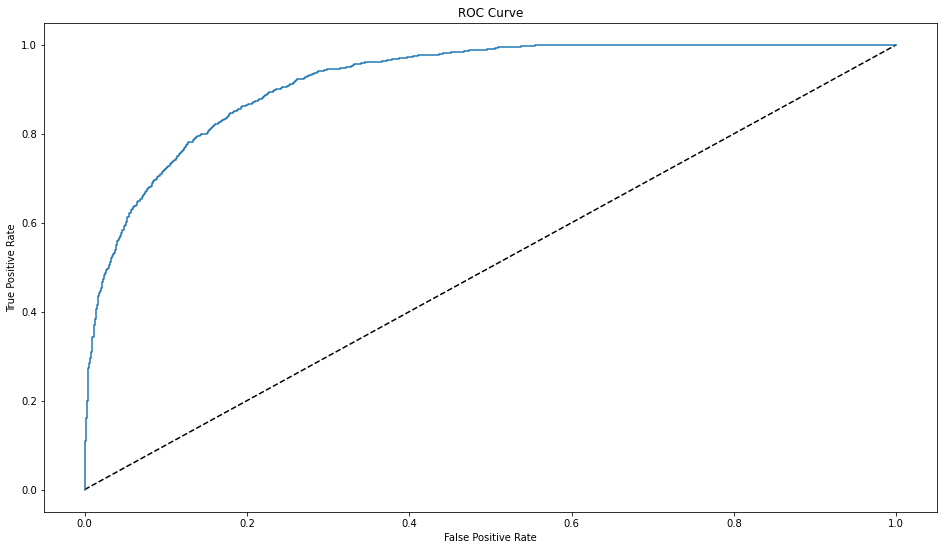

In [32]:
# Get predictions from the data
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)

# Get evaluation metrics
cm = confusion_matrix(y_test, predictions)
print("Confusion matrix: \n", cm, "\n")
print("Accuracy: \n", accuracy_score(y_test, predictions))
print("Overall Precision: \n", precision_score(y_test, predictions))
print("Overall Recall: \n", recall_score(y_test, predictions))
auc = roc_auc_score(y_test, y_scores[:,1])
print("AUC: " + str(auc))

# Calculate ROC wave
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# Plot ROC curve
fig = plt.figure(figsize=(16,9))

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


The results look a little better, so clearly preprocessing the data has made a difference.

### Try a different algorithm

Now let's try a different algorithm. Previously we used a logistic regression algorithm, which is a *linear* algorithm. There are many kinds of classification algorithm we could try, including:

- **Support Vector Machine algorithms**: Algorithms that define a *hyperplane* that separates classes.
- **Tree-based algorithms**: Algorithms that build a decision tree to reach a prediction
- **Ensemble algorithms**: Algorithms that combine the outputs of multiple base algorithms to improve generalizability.

This time, We'll use the same preprocessing steps as before, but we'll train the model using an *ensemble* algorithm named *Random Forest* that combines the outputs of multiple random decision trees (for more details, see the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)).

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logregressor', RandomForestClassifier(n_estimators=100))])

# fit the pipeline to train a random forest model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [7])])),
                ('logregressor', RandomForestClassifier())])


Confusion Matrix:
 [[2857  129]
 [ 184 1330]] 

Accuracy: 0.9304444444444444
Overall Precision: 0.9115832762165867
Overall Recall: 0.8784676354029062

AUC: 0.9823165304224647


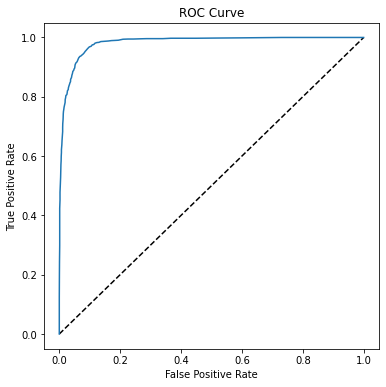

In [34]:
predictions = model.predict(X_test)
y_scores = model.predict_proba(X_test)
cm = confusion_matrix(y_test, predictions)
print ('Confusion Matrix:\n',cm, '\n')
print('Accuracy:', accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions))
print("Overall Recall:",recall_score(y_test, predictions))
auc = roc_auc_score(y_test,y_scores[:,1])
print('\nAUC: ' + str(auc))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# plot ROC curve
fig = plt.figure(figsize=(6, 6))
# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], 'k--')
# Plot the FPR and TPR achieved by our model
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [35]:
# Use the model for inferencing
import joblib

# Save the model as a pickle file
filename = './diabetes_model.pkl'
joblib.dump(model, filename)

['./diabetes_model.pkl']

In [36]:
# Load the model from the file
model = joblib.load(filename)

# predict on a new sample
# The model accepts an array of feature arrays (so you can predict the classes of multiple patients in a single call)
# We'll create an array with a single array of features, representing one patient
X_new = np.array([[2,180,74,24,21,23.9091702,1.488172308,22]])
print ('New sample: {}'.format(list(X_new[0])))

# Get a prediction
pred = model.predict(X_new)

# The model returns an array of predictions - one for each set of features submitted
# In our case, we only submitted one patient, so our prediction is the first one in the resulting array.
print('Predicted class is {}'.format(pred[0]))

New sample: [2.0, 180.0, 74.0, 24.0, 21.0, 23.9091702, 1.488172308, 22.0]
Predicted class is 1
